In [122]:
import pandas as pd
from datetime import datetime
import numpy as np

# Interact
import ipywidgets as widgets
from ipywidgets import Dropdown, interact, fixed
import ipyvuetify as v

# Stats
from scipy import stats
from numpy import mean
from numpy import std
from scipy import mean
from scipy.stats import sem, t

# Graphs
import plotly.figure_factory as ff
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [123]:
# Load data
pre = 'https://raw.githubusercontent.com/gabai/phys_training/master/Pre-coaching.csv'
post = 'https://raw.githubusercontent.com/gabai/phys_training/master/Post-coaching.csv'
merge = 'https://raw.githubusercontent.com/gabai/phys_training/master/Merge-coaching.csv'

# Load data and concatenate sheets (long format)
df1 = pd.read_csv(pre)
df1['Coaching'] = 'Pre-coaching'
#
df2 = pd.read_csv(post)
df2 ['Coaching'] = 'Post-coaching'
#
data = pd.concat([df1, df2], sort=False).reset_index(drop=True)

# Merged data for t-test 1:1 pre-post
merge = pd.read_csv(merge)

In [124]:
# Rename columns as space after name
data = data.rename(columns={'Provider ': 'Provider',
                            'Specialty': 'Specialty',
                            'Patients Seen ' : 'Patients Seen',
                            'After Hours % ': 'After Hours %',
                            'Orders Time ': 'Orders Time',
                            'Other Time ': 'Other Time'})

# Rename columns as space after name
merge = merge.rename(columns={'Provider ': 'Provider',
                              'Specialty': 'Specialty',
                              'Patients Seen _pre' : 'Patients Seen_pre',
                              'After Hours % _pre': 'After Hours %_pre',
                              'Orders Time _pre': 'Orders Time_pre',
                              'Other Time _pre': 'Other Time_pre',
                              'Patients Seen _post' : 'Patients Seen_post',
                              'After Hours % _post': 'After Hours %_post',
                              'Orders Time _post': 'Orders Time_post',
                              'Other Time _post': 'Other Time_post'})

In [125]:
# Convert time variables to seconds - Data dataset
time_vars = ['Time Per Patient', 'Orders Time', 'Doc Time', 'Chart Review Time', 'MPage Chart Review Time',
            'Flowsheet Chart Review Time', 'Clnical Notes Chart Review Time', 'Doc Viewer Chart Review Time',
            'Other Chart Review Time', 'Other Time']

for i in time_vars:
    data[i] = pd.to_datetime(data[i], format='%H:%M:%S')
    time = pd.DatetimeIndex(data[i])
    data[i] = time.hour * 60 + time.minute * 60 + time.second
    
# Convert time variables to seconds - Merge dataset
time_vars = ['Time Per Patient_pre', 'Orders Time_pre', 'Doc Time_pre', 'Chart Review Time_pre', 'MPage Chart Review Time_pre',
            'Flowsheet Chart Review Time_pre', 'Clnical Notes Chart Review Time_pre', 'Doc Viewer Chart Review Time_pre',
            'Other Chart Review Time_pre', 'Other Time_pre', 'Time Per Patient_post', 'Orders Time_post', 'Doc Time_post', 
            'Chart Review Time_post', 'MPage Chart Review Time_post',
            'Flowsheet Chart Review Time_post', 'Clnical Notes Chart Review Time_post', 'Doc Viewer Chart Review Time_post',
            'Other Chart Review Time_post', 'Other Time_post']

for i in time_vars:
    merge[i] = pd.to_datetime(merge[i], format='%H:%M:%S')
    time = pd.DatetimeIndex(merge[i])
    merge[i] = time.hour * 60 + time.minute * 60 + time.second

In [126]:
# Modify Data
# Replace not mapped and unknown with other for general grouping
data['Specialty'].replace(to_replace=['[Not Mapped]', '[Unknown]'], value='Other', inplace=True)
merge['Specialty'].replace(to_replace=['[Not Mapped]', '[Unknown]'], value='Other', inplace=True)

# Convert int to numeric
var_int = ['Patients Seen', 'Time Per Patient', 'Doc Time', 'Chart Review Time']
for i in var_int:
    data[i] = data[i].astype(float)
    merge[i+'_pre'] = merge[i+'_pre'].astype(float)
    merge[i+'_post'] = merge[i+'_post'].astype(float)

# Round decimals to 4
data = data.round(4)
merge = merge.round(4)


In [127]:
# List of variables used for analysis
stats_list = ['Patients Seen', 'Time Per Patient', 'Adoption Score', 'After Hours %', 'Orders Time', 'Doc Time', 
              'Chart Review Time', 'MPage Chart Review Time', 'Flowsheet Chart Review Time', 
              'Clnical Notes Chart Review Time', 'Doc Viewer Chart Review Time', 'Other Chart Review Time', 
              'Other Time', 'CPOE %', 'E-Doc %', 'Edoc % Authored', 'Transcription %', 'Dyn Doc %',  
              'Clinical Note %', 'Power Note %']

In [128]:
# List of variables used for graphs (removed those wiht limited values)
graph_list = ['Patients Seen', 'Time Per Patient', 'Adoption Score', 'After Hours %', 'Orders Time', 'Doc Time', 
              'Chart Review Time', 'MPage Chart Review Time',  'Flowsheet Chart Review Time', 
              'Clnical Notes Chart Review Time', 'Doc Viewer Chart Review Time',  'Other Chart Review Time', 
              'Other Time',  'CPOE %',  'E-Doc %', 'Edoc % Authored', 'Dyn Doc %']

# Personalized coaching sessions for continuous EMR education, effect on physician performance.

## Kaleida Health

### Summary
Coaching sessions from January – August 2019.
<br>
Coached a total of 159 providers for 33 specialties.
<br>
Up to three coaching sessions, lasting 1 hour each.
<br>
***

In [129]:
# Summary Table
df = data.describe()
df.style.set_caption("Summary Table of Variables")

,Patients Seen,Time Per Patient,Adoption Score,After Hours %,Orders Time,Doc Time,Chart Review Time,MPage Chart Review Time,Flowsheet Chart Review Time,Clnical Notes Chart Review Time,Doc Viewer Chart Review Time,Other Chart Review Time,Other Time,CPOE %,E-Doc %,Edoc % Authored,Transcription %,Dyn Doc %,Clinical Note %,Power Note %
count,344,344,344,267,341,344,344,338,331,335,343,338,341,334,344,337,10,337,135,14
mean,108.753,1111.36,0.875104,0.247512,176.633,471.939,418.698,113.855,116.045,32.609,131.79,32.5769,176.633,0.779907,0.992967,0.757296,0.24154,0.956347,0.0757067,0.649657
std,85.946,758.252,0.155004,0.214569,209.359,426.231,420.716,166.383,156.718,67.3384,137.692,53.3912,209.359,0.265169,0.062983,0.323523,0.295993,0.139552,0.157279,0.427323
min,2,68,0.0278,0.0001,0,0,1,0,0,0,1,0,0,0.0133,0.0556,0.0041,0.02,0.01,0,0
25%,41,474,0.81825,0.07705,46,181.75,136,20,19,2,41.5,6,46,0.67515,1,0.5355,0.056975,0.98,0.01,0.205
50%,97.5,947.5,0.949,0.2033,108,333,304.5,52.5,57,9,99,19,108,0.9085,1,0.955,0.12,1,0.0206,0.9094
75%,155.25,1560.25,0.985375,0.3544,245,669,543,154.75,157.5,27,176.5,39,245,0.97125,1,1,0.26745,1,0.0606,0.9975
max,731,3588,1,1,1728,3096,2691,1552,1255,495,891,653,1728,1,1,1,0.94,1,0.88,1


***

In [130]:
# Table of coaching sessions by specialty (Top 10)
df = data['Specialty'].value_counts().reset_index(drop=False)
df['Sample'] = df['Specialty']/2
df = df.rename(columns={'index': 'Group',
                            'Specialty': 'Total Coaching Sessions'
                           })
df[0:10].style.hide_index().set_caption("Table of Coaching Sessions by Specialty - Top 10")

Group,Total Coaching Sessions,Sample
Student,36,18
Hospitalist,34,17
Obstetrics & Gynecology,34,17
Internal Medicine,32,16
Pediatrics,32,16
Cardiology,24,12
Orthopaedics,18,9
General Surgery,18,9
Otolaryngology (ENT),16,8
Family Medicine,10,5


In [143]:
# # Function to remove outliers from dataset
# def outliers(data):
#     # Calculate outliers
#     data_mean, data_std = mean(data[Variable]), std(data[Variable])
#     cut_off = data_std * 3
#     lower, upper = data_mean - cut_off, data_mean + cut_off 
#     #
#     df1 = data[(data[Variable]>=lower) & (data[Variable]<=upper)] # Create dataset (long) without the outlier
#     df1 = df1[(df1['Patients Seen']>=50) & (df1['Patients Seen']>=50)] # Select providers with more than 50 patients

***

### Paired TTest Analysis

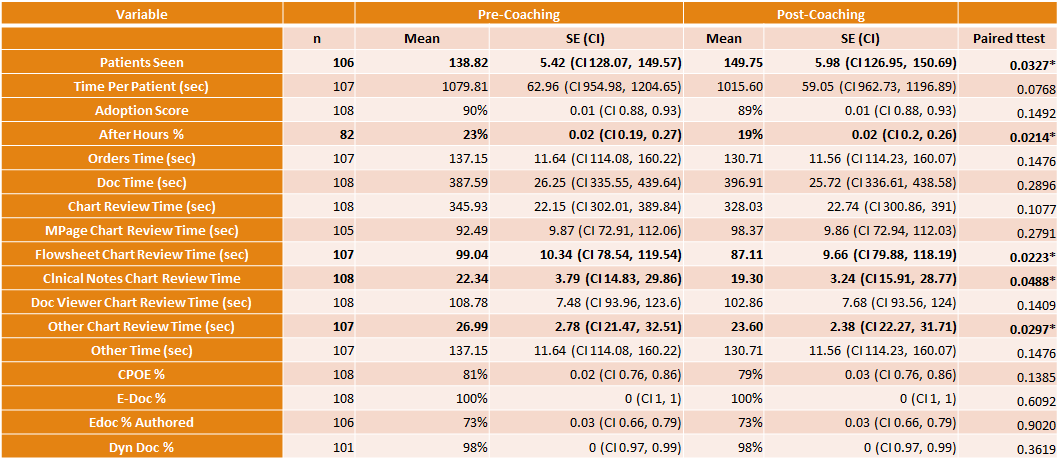

***

### Histogram of variables

In [154]:
# Histogram of Variables
@interact
def response(Variable=graph_list, *ignore):
    # Calculate outliers
    data_mean, data_std = mean(data[Variable]), std(data[Variable])
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off 
    #
    df1 = data[(data[Variable]>=lower) & (data[Variable]<=upper)] # Create dataset (long) without the outlier
    df1 = df1[(df1['Patients Seen']>=50) & (df1['Patients Seen']>=50)] # Select providers with more than 50 patients
    fig = px.histogram(df1, x=Variable,
                       title='Histogram of '+Variable)
    fig.show()

interactive(children=(Dropdown(description='Variable', options=('Patients Seen', 'Time Per Patient', 'Adoption…

***

### Histogram of variables by coaching

In [137]:
# Histogram of Variables by Coaching status
@interact
def response(Variable=graph_list, *ignore):
    # Calculate outliers
    data_mean, data_std = mean(data[Variable]), std(data[Variable])
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off 
    #
    df1 = data[(data[Variable]>=lower) & (data[Variable]<=upper)] # Create dataset (long) without the outlier
    df1 = df1[(df1['Patients Seen']>=50) & (df1['Patients Seen']>=50)] # Select providers with more than 50 patients
    fig = px.histogram(df1, x=Variable,
                       color = 'Coaching',
                       marginal="box",
                       title='Histogram of '+Variable+' by Coaching')
    fig.show()

interactive(children=(Dropdown(description='Variable', options=('Patients Seen', 'Time Per Patient', 'Adoption…

***

### Stacked histogram of average by specialty and coaching

In [145]:
# Stacked histo of average for variables in dataset by specialty and coaching
@interact
def response(Variable=graph_list, *ignore):
    # Calculate outliers
    data_mean, data_std = mean(data[Variable]), std(data[Variable])
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off 
    #
    df1 = data[(data[Variable]>=lower) & (data[Variable]<=upper)] # Create dataset (long) without the outlier
    df1 = df1[(df1['Patients Seen']>=50) & (df1['Patients Seen']>=50)] # Select providers with more than 50 patients
    fig = px.histogram(df1, x="Specialty", y=Variable, 
                       histfunc='avg',
                       color='Coaching')
    fig.show()

interactive(children=(Dropdown(description='Variable', options=('Patients Seen', 'Time Per Patient', 'Adoption…

### Grouped bar chart of variables by specialty and coaching

In [152]:
# General graphs of main variables by coaching and specialty
@interact
def response(Variable=graph_list, *ignore):
    # Calculate outliers
    data_mean, data_std = mean(data[Variable]), std(data[Variable])
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off 
    #
    df1 = data[(data[Variable]>=lower) & (data[Variable]<=upper)] # Create dataset (long) without the outlier
    df1 = df1[(df1['Patients Seen']>=50) & (df1['Patients Seen']>=50)] # Select providers with more than 50 patients
    df2 = df1.groupby(['Coaching', 'Specialty']).mean().sort_values(by='Coaching', ascending=False).reset_index()
    bar = px.bar(df2, x='Specialty', y=Variable, color='Coaching', barmode='group',
                title='Average of '+Variable+' (time measured in seconds)') 
    bar.show()

interactive(children=(Dropdown(description='Variable', options=('Patients Seen', 'Time Per Patient', 'Adoption…

***

### Box plot of variables by coaching

In [153]:
# Box plot of variables by coaching and specialty
@interact
def response(Variable=graph_list, *ignore):
    data_mean, data_std = mean(data[Variable]), std(data[Variable])
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off 
    #
    df1 = data[(data[Variable]>=lower) & (data[Variable]<=upper)] # Create dataset (long) without the outlier
    df1 = df1[(df1['Patients Seen']>=50) & (df1['Patients Seen']>=50)] # Select providers with more than 50 patients
    fig = px.box(df1, x="Coaching", y=Variable,
                title='Boxplot of '+Variable)
    fig.show()    

interactive(children=(Dropdown(description='Variable', options=('Patients Seen', 'Time Per Patient', 'Adoption…

***

### Difference plot by specialty

In [94]:
# Create difference table
df1 = data.groupby(['Coaching', 'Specialty']).mean().sort_values(by=['Specialty', 'Coaching'], ascending=[True, False]).reset_index()
df2 = df1.groupby('Specialty').diff()
df2 = df2.dropna(how='all')
diff = df2.merge(df1['Specialty'], left_index = True, right_index = True)

In [95]:
# Difference plot of variables by coaching and specialty
@interact
def response(Variable=graph_list, *ignore):
    bar = px.bar(diff, x='Specialty', y=Variable, barmode='group',
                title='Difference in pre-post coaching for '+Variable)    
    bar.show()

interactive(children=(Dropdown(description='Variable', options=('Patients Seen', 'Time Per Patient', 'Adoption…

***

### Statistical Analysis - Paired t test

In [176]:
# Remove Outliers and create dataset - Comparison Means pre-post
df0 = []
y = ['n', 'Mean Pre-Coaching', 'Standard Error Pre-Coaching', 'CI Low Pre-Coaching', 'CI High Pre-Coaching',
     'Mean Post-Coaching', 'Standard Error Post-Coaching', 'CI Low Post-Coaching', 'CI High Post-Coaching',
     'Paired ttest']
confidence = 0.95

for i in stats_list:
    # Calculate outliers
    data_mean, data_std= mean(data[i]), std(data[i])
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off 
    # Remove outlier and create dataset for each variable
    df = merge[(merge[i+'_pre']>=lower) & (merge[i+'_pre']<=upper) 
               & (merge[i+'_post']>=lower) & (merge[i+'_post']<=upper)] 
    # Select providers with more than 50 patients
    paired = df[(df['Patients Seen_pre']>=50) & (df['Patients Seen_post']>=50)] # Select providers with more than 50 patients
    
    # Confirdence intervals - Pre coaching
    n=len(paired[i+'_pre'])
    m_pre = mean(paired[i+'_pre'])
    m_post = mean(paired[i+'_post'])
    std_err_pre = sem(paired[i+'_pre'])
    std_err_post = sem(paired[i+'_post'])
    h_pre = std_err_pre * t.ppf((1 + confidence) / 2, n - 1)
    h_post = std_err_post * t.ppf((1 + confidence) / 2, n - 1)
    CI_low_pre = m_pre-h_pre
    CI_high_pre = m_pre+h_pre
    CI_low_post = m_pre-h_post
    CI_high_post = m_pre+h_post
    
    # Rows for dataset
    row=[]
    row.append(len(paired))
    row.append(m_pre)
    row.append(std_err_pre)
    row.append(CI_low_pre)
    row.append(CI_high_pre)
    row.append(m_post)
    row.append(std_err_post)
    row.append(CI_low_post)
    row.append(CI_high_post)
    ttest = stats.ttest_rel(paired[i+'_pre'], paired[i+'_post'],
                            nan_policy='omit')
    row.append(ttest)
    
    df0.append(row)
       
df0 = pd.DataFrame(df0, index=stats_list, columns=y)

df0

,n,Mean Pre-Coaching,Standard Error Pre-Coaching,CI Low Pre-Coaching,CI High Pre-Coaching,Mean Post-Coaching,Standard Error Post-Coaching,CI Low Post-Coaching,CI High Post-Coaching,Paired ttest
Patients Seen,106,138.820755,5.422886,128.068174,149.573336,149.754717,5.984373,126.954848,150.686662,"(-2.164174035627173, 0.03271738694794503)"
Time Per Patient,107,1079.813084,62.963968,954.980893,1204.645275,1015.598131,59.054125,962.732538,1196.893631,"(1.7868726633381469, 0.07681644758135808)"
Adoption Score,108,0.904298,0.011654,0.881195,0.927401,0.894947,0.012843,0.878839,0.929757,"(1.452723792757541, 0.1492267853406027)"
After Hours %,82,0.230180,0.019765,0.190854,0.269507,0.191398,0.016223,0.197901,0.262460,"(2.347264219493211, 0.021353229373037474)"
Orders Time,107,137.149533,11.637063,114.077924,160.221142,130.710280,11.562683,114.225388,160.073677,"(1.4586409789755415, 0.14762077393557782)"
Doc Time,108,387.592593,26.254509,335.546090,439.639095,396.907407,25.718217,336.609226,438.575959,"(-1.0642838250694586, 0.28959602219356906)"
Chart Review Time,108,345.925926,22.150656,302.014834,389.837018,328.027778,22.735257,300.855931,390.995921,"(1.6221732945773284, 0.10770920498519226)"
MPage Chart Review Time,105,92.485714,9.871789,72.909586,112.061842,98.371429,9.856129,72.940641,112.030787,"(-1.08793754617183, 0.2791375170332631)"
Flowsheet Chart Review Time,107,99.037383,10.340099,78.537132,119.537634,87.112150,9.662478,79.880580,118.194186,"(2.3193789539693266, 0.02229171806460938)"
Clnical Notes Chart Review Time,108,22.342593,3.790237,14.828889,29.856296,19.296296,3.242967,15.913789,28.771396,"(1.9932798832931031, 0.04877606945543129)"
